<a href="https://colab.research.google.com/github/emiliomercuri/ciencia_dados/blob/main/aulas/2023_11_29_Aula_13_PyTorch_(Visa%CC%83o_Computacional%20ConvNET).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch - Visão Computacional (Computer Vision)

Nas próximas aulas vamos trabalhar com Convolutional Neural Networks (CNN) para classificação de imagens. Hoje vamos construir um modelo de RNA para servir como Baseline Model. Um baseline model é um modelo mais simples que será usado para avaliar a eficiência da CNN.

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## 1. Obtendo o dataset

O conjunto de dadeos que vamos usar é o Fashion MNIST

In [2]:
# Baixando o Fashion MNIST dataset do torchvision.datasets
train_data = datasets.FashionMNIST(
    root="data", # onde vamos fazer o download
    train=True, # conjunto de treinamento
    download=True, # fazer o download na máquina virtual do Google
    transform=torchvision.transforms.ToTensor(),  # Transformar em Tensores
    target_transform=None # como queremos transformar os labels/target
)

test_data = datasets.FashionMNIST(
    root="data", # onde vamos fazer o download
    train=False, # conjunto de teste
    download=True, # fazer o download na máquina virtual do Google
    transform=torchvision.transforms.ToTensor(),  # Transformar em Tensores
    target_transform=None # como queremos transformar os labels/target
)

100%|██████████| 26421880/26421880 [00:01<00:00, 17141092.52it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 272174.17it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5074038.44it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14140325.47it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
# visualizer uma primeira imagem do conjunto de treinamento
image, label = train_data[0]
#image, label

In [5]:
image.shape

torch.Size([1, 28, 28])

In [6]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [8]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

## 1.2 Visualizando os dados

Text(0.5, 1.0, '9')

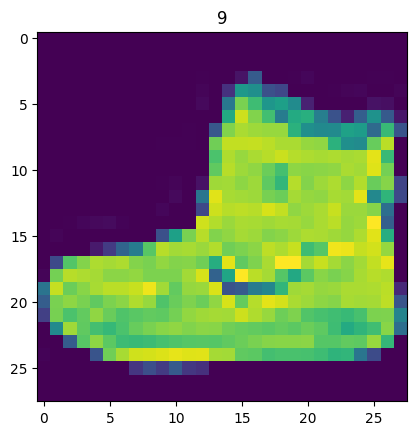

In [9]:
image, label = train_data[0]
plt.imshow(image.squeeze())
plt.title(label)

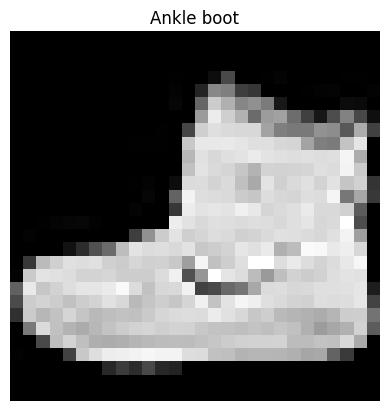

In [10]:
plt.imshow(image.squeeze(),cmap="gray")
plt.title(class_names[label])
plt.axis(False);

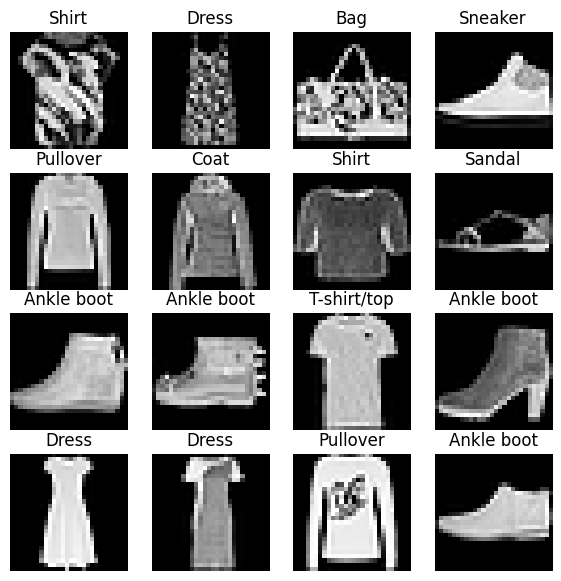

In [11]:
# Plot more images
#torch.manual_seed(42)
fig = plt.figure(figsize=(7,7))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  #print(i)
  random_idx = torch.randint(0,len(train_data), size=[1]).item()
  #print(random_idx)
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False);

In [12]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## 2. Preparando o DataLoader

Por enquanto os dados que temos estão na forma de PyTorch Datasets.

DataLoader transforma o nosso dataset em um Python iterable (iterável em Python).

Mais especificamente, queremos transformar os nossos dados em batches (lotes de imagens/dados) ou minibatches.

Mais informações:
https://www.youtube.com/watch?v=4qJaSmvhxi8&ab_channel=DeepLearningAI

### Vamos organizar os nossos batches assim:


<img src="https://www.dropbox.com/scl/fi/b0tewg1iqs3kivs55qmqa/batches.png?rlkey=4j99j0g15z6y6s82f0mg429rm&dl=1" width="800"/>



In [13]:
from torch.utils.data import DataLoader

# Definindo o tamanho dos lotes (batches)
BATCH_SIZE = 32

# Transformar o dataset em iterable
train_dataloader = DataLoader(dataset=train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7933172bb220>,
 <torch.utils.data.dataloader.DataLoader at 0x7933172bb970>)

In [14]:
# Verificar o que temos dentro da cada DataLoader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))


<img src="https://www.dropbox.com/scl/fi/1x17q6rsawalux5et3fnu/03-computer-vision-input-and-output-shapes.png?rlkey=2b755skiyxtre507kpf25oicf&dl=1" width="800"/>

## 3. Model 0: Construindo um Baseline Model

Começar simples e adicionar complexidade quando necessário.

In [15]:
# Criar uma flatten layer
flatten_model = nn.Flatten()

# Visualizando uma amostra
x = train_features_batch[0]

# "Achatando" a amostra
output = flatten_model(x)

# Imprimir o que está acontecendo
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [16]:
# Construindo o modelo
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
              input_shape: int,
              hidden_units: int,
              output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self,x):
    return self.layer_stack(x)

In [17]:
torch.manual_seed(42)

# Configurando os parâmetros do nosso modelo
model_0 = FashionMNISTModelV0(
    input_shape = 784, # 28*28
    hidden_units = 10,
    output_shape = len(class_names)
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [18]:
dummy_x = torch.rand([1,1,28,28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

Veja que nós obtivemos uma saída de 10 logits!! 1 logit para cada classe!

In [19]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

## 3.1 Configurar uma função perda, otimizador e métricas para avaliar o modelo

* Loss function - `nn.CrossEntropyLoss()`
* Optimizer - `torch.optim.SGD()`
* Métrica - Acurácia

In [20]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/emiliomercuri/ciencia_dados/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [21]:
from helper_functions import accuracy_fn

# configurar a função erro e otimizador
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                             lr=0.1)

## Criando uma função para calcular o tempo de processamento dos nossos experimentos

In [22]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Imprime a diferença entre o tempo de início e final da simulação"""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [23]:
start_time = timer()
# alguns códigos
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")

Train time on cpu: 0.000 seconds


4.9279999984719325e-05

## 3.3 Criando loop de treinamento e test do nosso modelo para analisar os batches dos dados

In [24]:
from os import XATTR_SIZE_MAX
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# épocas
epochs = 3

# Criando o loop de treinamento e test
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-----")
  # Training
  train_loss = 0
  for batch, (X,y) in enumerate(train_dataloader):
    model_0.train()
    y_pred = model_0(X)
    loss = loss_fn(y_pred,y)
    train_loss += loss # accumulate train loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # dividindo a função perda pelo comprimento do train_dataloder
  train_loss /= len(train_dataloader) # A \= B é equivalente a A = A / B

  ### Testing
  test_loss, test_acc = 0,0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      test_pred = model_0(X_test)
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
    # dividindo a função perda pelo comprimento do test_dataloder
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  # Print out what's happening
  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----

Train loss: 0.5904 | Test loss: 0.5102, Test acc: 82.0387
Epoch: 1
-----

Train loss: 0.4743 | Test loss: 0.5268, Test acc: 81.6793
Epoch: 2
-----

Train loss: 0.4537 | Test loss: 0.5126, Test acc: 82.9972
Train time on cpu: 29.537 seconds


# 4. Fazendo predições e obtendo resultados do Model 0

In [25]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # Make predictions
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.512529730796814,
 'model_acc': 83.00718849840256}

## Configurar o device agnostic-code (código independente do dispositivo)

In [26]:
!nvidia-smi

Wed Nov 29 12:42:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 6. Model 1: Building a better model with non-linearity and use GPU!!

We learned about the power of non-linearity

In [28]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(), # flatten inputs into a single vector
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [29]:
# Create an instance of model_1
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, # this is the output of the flatten after our 28*28 image goes in
                              hidden_units=10,
                              output_shape=len(class_names)).to(device) # send to the GPU if it's available
next(model_1.parameters()).device

device(type='cuda', index=0)

In [30]:
loss_fn = nn.CrossEntropyLoss() # measure how wrong our model is
optimizer = torch.optim.SGD(params=model_1.parameters(), # tries to update our model's parameters to reduce the loss
                            lr=0.1)

In [31]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """Performs a training with model trying to learn on data_loader."""
  train_loss, train_acc = 0, 0

  # Put model into training mode
  model.train()

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):
    # Put data on target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass (outputs the raw logits from the model)
    y_pred = model(X)

    # 2. Calculate loss and accuracy (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1)) # go from logits -> prediction labels

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (update the model's parameters once *per batch*)
    optimizer.step()

  # Divide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [32]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Performs a testing loop step on model going over data_loader."""
  test_loss, test_acc = 0, 0

  # Put the model in eval mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Send the data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass (outputs raw logits)
      test_pred = model(X)

      # 2. Calculuate the loss/acc
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1)) # go from logits -> prediction labels

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

In [33]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Set epochs
epochs = 3

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n----------")
  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
Train loss: 1.09199 | Train acc: 61.34%
Test loss: 0.95690 | Test acc: 64.98%

Epoch: 1
----------
Train loss: 0.73779 | Train acc: 73.69%
Test loss: 0.72388 | Test acc: 74.21%

Epoch: 2
----------
Train loss: 0.66776 | Train acc: 76.08%
Test loss: 0.68751 | Test acc: 75.64%

Train time on cuda: 34.674 seconds


> **Observação:** Às vezes, dependendo dos seus dados/hardware, você pode descobrir que seu modelo treina mais rápido na CPU do que na GPU.
>
> Por que isso acontece?
>
> 1. Pode ser que a sobrecarga para copiar dados/modelo de e para a GPU supere os benefícios de computação oferecidos pela GPU.
> 2. O hardware que você está usando tem uma CPU melhor em termos de capacidade de computação do que a GPU.
>
> Para saber mais sobre como fazer seus modelos computarem mais rápido, veja aqui: https://horace.io/brrr_intro.html

In [34]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.512529730796814,
 'model_acc': 83.00718849840256}

In [35]:
# Train time on CPU
total_train_time_model_0

29.537037964000035

In [37]:
# Get model_1 results dictionary
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

RuntimeError: ignored

In [38]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # Make our data device agnostic
      X, y = X.to(device), y.to(device)
      # Make predictions
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

In [39]:
# Get model_1 results dictionary
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6881523728370667,
 'model_acc': 75.61900958466454}

In [40]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.512529730796814,
 'model_acc': 83.00718849840256}

## Modelo 2: Construindo uma Rede Neural Convolucional

* Convolution Neural Network -> ConvNET

* CNN's são conhecidas pela sua capacidade de encontrar padrões em imagens.

<img src="https://www.dropbox.com/scl/fi/zp2fben8xabnrp7e8zfiz/CNN.png?rlkey=geom2rql2tz2ci5ms0208zy51&dl=1" width="1000"/>

Material extra classe: https://poloclub.github.io/cnn-explainer/

Learn Convolutional Neural Network (CNN) in your browser!

In [66]:
# Criando uma Rede Neural Convolucional
class FashionMNISTModelV2(nn.Module):
  """
  Arquitetura de uma Rede Neural Convolucional do tipo TinyVGG
  https://regenerativetoday.com/complete-implementation-of-a-mini-vgg-network-for-image-recognition/
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        # Criando uma camada convolucional
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=(3,3),
                  stride=1,
                  padding=1), # hiperparâmetros da camada Conv2D
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=(3,3),
                  stride=1,
                  padding=1), # hiperparâmetros da camada Conv2D
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
            # Criando uma camada convolucional
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1), # hiperparâmetros da camada Conv2D
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1), # hiperparâmetros da camada Conv2D
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
    )
    # Os dois primeiro blocos vão servir como feature extractors, ou seja vão tentar "aprender" padrões dos dados
    # O próximo bloco vai receber os features e classificar nos target classes
    self.classifier = nn.Sequential(
        nn.Flatten(),
        #nn.Linear(in_features=hidden_units*0, # nem sempre é fácil achar o in_features... tem um truque.
        nn.Linear(in_features=hidden_units*7*7, # fizemos o truque!
                  out_features=output_shape)
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x

In [67]:
image.shape

torch.Size([1, 28, 28])

In [68]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape = 1, # número de canais de cores
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

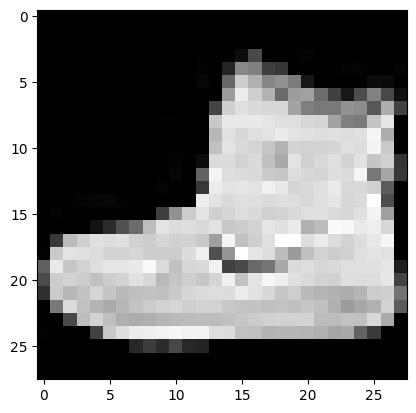

In [69]:
plt.imshow(image.squeeze(), cmap="gray");

In [70]:
rand_image_tensor = torch.randn(size=(1,28,28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [71]:
rand_image_tensor.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [72]:
rand_image_tensor.device

device(type='cpu')

In [73]:
#model_2.state_dict()

In [74]:
# Passar a imagem randômica pelo modelo
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Configurando a Função Perda e Otimizador do `modelo_2`

In [75]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

## Treinar e Testar o `model_2`

In [76]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Set epochs
epochs = 3

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n----------")
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_2,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
Train loss: 0.58929 | Train acc: 78.63%
Test loss: 0.38779 | Test acc: 85.97%

Epoch: 1
----------
Train loss: 0.35908 | Train acc: 87.02%
Test loss: 0.37008 | Test acc: 87.04%

Epoch: 2
----------
Train loss: 0.32471 | Train acc: 88.30%
Test loss: 0.34373 | Test acc: 87.62%

Train time on cuda: 40.990 seconds


In [77]:
# Get model_2 results
model_2_results = eval_model(
     model=model_2,
     data_loader=test_dataloader,
     loss_fn=loss_fn,
     accuracy_fn=accuracy_fn,
     device=device
)

model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3433931767940521,
 'model_acc': 87.60982428115015}

## Comparar os resultados dos modelos

In [78]:
import pandas as pd
compara_resultados = pd.DataFrame([model_0_results,
                                   model_1_results,
                                   model_2_results])
compara_resultados

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.512530,83.007188
1,FashionMNISTModelV1,0.688152,75.619010
2,FashionMNISTModelV2,0.343393,87.609824


In [79]:
compara_resultados["training_time"] = [total_train_time_model_0,
                                       total_train_time_model_1,
                                       total_train_time_model_2]

compara_resultados

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.512530,83.007188,29.537038
1,FashionMNISTModelV1,0.688152,75.619010,34.673525
2,FashionMNISTModelV2,0.343393,87.609824,40.990262


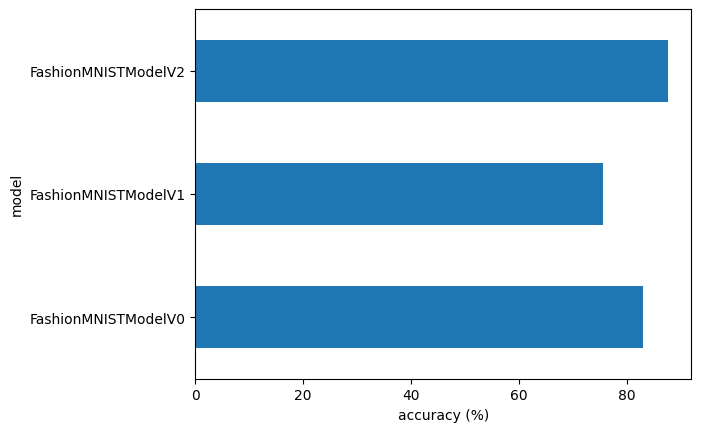

In [81]:
# Visualize our model results
compara_resultados.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

## Visualizando os resultados da classicação da nossa Tiny VGG (ConvNET)

In [82]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model outputs raw logits)
      pred_logit = model(sample)

      # Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [91]:
import random
#random.seed(42)
test_samples = []
test_labels = []
i = 0
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)
  print(i)
  i += 1

# View the first sample shape
test_samples[0].shape, test_labels[0]

0
1
2
3
4
5
6
7
8


(torch.Size([1, 28, 28]), 2)

In [92]:
# Make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

# View first two prediction probabilities
pred_probs[:2]

tensor([[4.9930e-02, 2.5107e-03, 5.0599e-01, 1.0606e-02, 3.2882e-01, 6.0000e-05,
         7.3226e-02, 3.3179e-04, 2.8422e-02, 1.0415e-04],
        [1.5609e-03, 6.9576e-04, 3.1494e-01, 2.3765e-03, 6.6192e-01, 4.2649e-06,
         3.7066e-03, 8.5505e-05, 1.4604e-02, 1.1316e-04]])

In [93]:
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 4, 6, 3, 2, 2, 0, 1, 1])

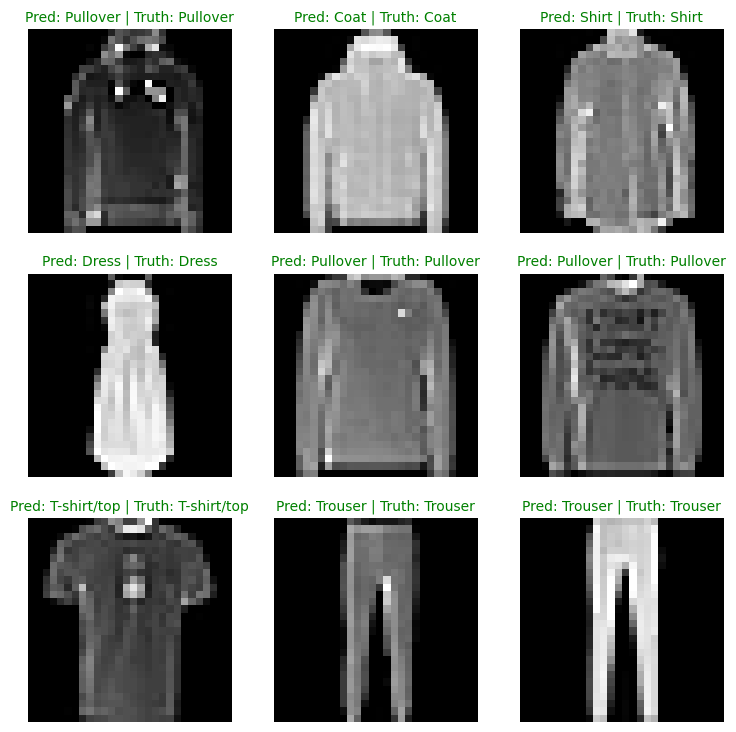

In [94]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction (in text form, e.g "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form)
  truth_label = class_names[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False);